In [1]:
import numpy as np
import os, sys

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import seaborn as sns
sns.set(style='ticks', palette='Set1')

# 1. Setup

* To compile and execute this code repo, you need [Snap](http://snap.stanford.edu/snap/index.html), with version 4.1 or later. Be sure to change the address to your Snap directory in Makefile.inc.
* Running RGCR experiment requires a lot of computation, and you are recommend you execute with multithread. You can specify the maximum number of thread to use in utils/meta.h. We recommend using at least 50 threads.

# 2. Data

* Along with this repo, we provides a series of heavy-tailed small-world networks, which are described in the paper. Each network is given as an edgelist in dataset/SWx.txt, where x is the length of the 2D-lattice the network is based on.
* Each network is associated with two files, *-node_meta.txt and *-response.txt.
  * In *-node_meta.txt, we provide some basic meta information of each node, including
    * Node Id
    * d1: node degree
    * d2: 2nd-order degree, defined as |B2(i)|-1
    * clu: local clustering coefficient
    * clo: local closure coefficient
    * n_triad: number of triangles at this node
    * eig1: corresponding element of largest eigenvector of the adjacency matrix $A$
    * eig2: corresponding element of largest eigenvector of $A^2$
  * In *-response.txt, we provide $h_i$ and $e_i$, the homophily and noise term in the response model. For details, see Section 6.2 of the paper.

We can visualize the node response Y_i, as well as the homophily h_i, with the following code

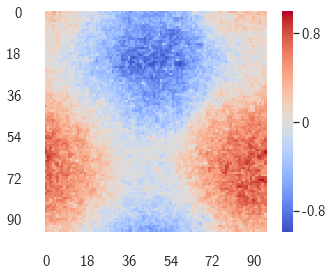

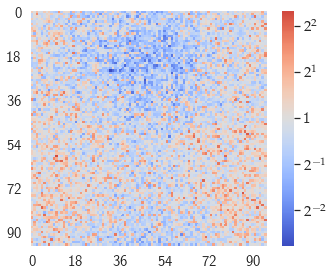

In [2]:
length = 96
graph_name = 'SW{}'.format(length)
response_he = np.loadtxt('dataset/{}-response.txt'.format(graph_name))

ticksize = 15
sns.set(font_scale=1)

h = response_he[:, 0].reshape((length, length)).T
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()
sns.heatmap(h, ax=ax, cbar=True, square=True, cmap="coolwarm", center=0, xticklabels=18, yticklabels=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=ticksize)
cbar.set_ticks([-0.8, 0, 0.8])
cbar.set_ticklabels(['-0.8', ' 0', ' 0.8'])
plt.setp(ax.get_xticklabels(), fontsize=ticksize)
plt.setp(ax.get_yticklabels(), fontsize=ticksize)
ax.tick_params(size=20)  # How comes it is invisible
plt.yticks(rotation=0) 
fig.tight_layout()
plt.show()

d1 = np.loadtxt('dataset/' + graph_name + '-node_meta.txt', usecols=1, skiprows=1)
y = (1+0.5*response_he[:, 0]+0.1*response_he[:, 1]) * d1
y /= d1.mean()
y = y.reshape((length, length)).T
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()
sns.heatmap(np.log(y), ax=ax, cbar=True, square=True, cmap="coolwarm", center=0, xticklabels=18, yticklabels=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=ticksize)
ticklabels = [r'$2^{-2}$', r'$2^{-1}$', '1', r'$2^{1}$', r'$2^{2}$']
ticks = np.log([0.25, 0.5, 1.0, 2.0, 4.0])
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
plt.setp(ax.get_xticklabels(), fontsize=ticksize)
plt.setp(ax.get_yticklabels(), fontsize=ticksize)
plt.yticks(rotation=0) 
fig.tight_layout()
plt.show()


# 3. Variance of HT estimator with mixing $K$ random clusterings

To reproduce Fig 3 on SW32, first compile the cpp code with command

    make

then execute the following commands:

    ./estimate_rgcr_expo_prob -g SW32 -c r_net-3 -w uniform -n 100000
    ./estimate_rgcr_expo_prob -g SW32 -c r_hop_max-1 -w uniform -n 100000

and then execute the following cells. Note that each ./estimate_rgcr_expo_prob execution takes ~30 minutes if 50 threads are used in execution.

To reproduce Fig 3 on SW96, each ./estimate_rgcr_expo_prob execution takes ~70 hours.

In [3]:
def parse_file(file_name, values):
    file_input = open(file_name, 'r')
    for line in file_input:
        line = line.strip()
        try:
            # ValueError possibility: str -> float may fail.
            v = float(line)
        except ValueError:
            count_invalid += 1
            print("invalid number in ", filename, ": ln ", count + count_invalid)
            print(line)
            continue
        values.append(v)
    return
    
      
def get_value(result_paths, file_path_name):
    values = []
    for result_path in result_paths:
        parse_file(result_path + file_path_name, values)
    if (len(values) <= 40) :
        lb = min(values)
        ub = max(values)
    else :
        lb = np.quantile(values, 0.025)
        ub = np.quantile(values, 0.975)
    m = np.quantile(values, 0.5)
    return m, lb, ub


def read_variance_all_levels(result_paths, graph_name, method_hop, score, types):
    medians = []
    lbs = []
    ubs = []
    for tp in types:
        file_path_name = graph_name + '/variance/' + method_hop + '-' + score + '-' + tp + '.txt'
        stats = get_value(result_paths, file_path_name)
        medians.append(stats[0])
        lbs.append(stats[1])
        ubs.append(stats[2])
    return medians, lbs, ubs


ind r_net-3 uniform
[573.6579999999999, 56.197649999999996, 14.57165, 4.585430000000001, 4.2554099999999995, 4.23013]
ind r_hop_max-1 uniform
[920596.5, 29920.050000000003, 11.1706, 3.099915, 2.9745600000000003, 2.96164]


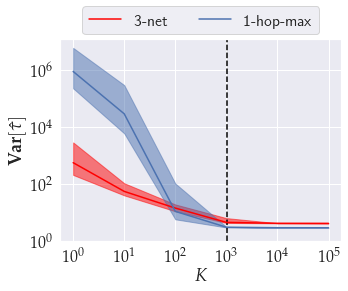

In [4]:
fsz = 18
fig = plt.figure(figsize=(5, 4.3))
ax = fig.gca()
plt.xscale('log')
plt.yscale('log')
ax.axvline(32*32, color='black', linestyle='--')

graph_name = 'SW32'

result_path = 'results/'
randomization = 'ind/'
var_types = ['var_single', 'var_mix10', 'var_mix100', 'var_mix1000', 'var_mix10000', 'var_mix100000']
n_mixings = [10**i for i in range(len(var_types))]
options = [
    [[result_path+randomization], 'r_net-3', 'uniform', 'red'],
    [[result_path+randomization], 'r_hop_max-1', 'uniform', 'b'],
]
for result_paths, method_hop, score, c in options:
    medians, lbs, ubs = read_variance_all_levels(result_paths, graph_name, method_hop, score, var_types)
    print(randomization[:3], method_hop, score)
    print(medians)
    ax.fill_between(n_mixings, ubs, lbs, color=c, alpha=.5)
    legend = '3-net' if method_hop == 'r_net-3' else '1-hop-max'
    ax.plot(n_mixings, medians, color=c, label=legend)


# ax.set_title("Variance at each mixing level", fontsize=fsz)
ax.set_xlabel(r"$K$", fontsize=fsz)
ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$', fontsize=fsz)
ax.set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks(np.array([1, 10**2, 10**4, 10**6], dtype=np.float))
ax.xaxis.set_tick_params(which='major', width=1, size=5)
ax.xaxis.set_tick_params(which='minor', width=0, size=0)
ax.yaxis.set_tick_params(which='major', width=1, size=5)
ax.yaxis.set_tick_params(which='minor', width=0, size=0)
plt.setp(ax.get_xticklabels(), fontsize=fsz-2)
plt.setp(ax.get_yticklabels(), fontsize=fsz-2)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz-2, ncol=2)
fig.tight_layout()
# fig.savefig('fig/GCR-HT-SW96.pdf')
plt.show()

# 4. Estimate exposure probabilities

To estimate the exposure probabilities with stratified MC sampling, use command

    ./estimate_rgcr_expo_prob -g SW32 -c [method] -w [weight] -s -n 128 [-t]

where adding the optional flag -t would analyze complete randomization (as opposed to independent randomization).

To reproduce Fig 5 and 6, first execute commands

    ./estimate_rgcr_expo_prob -g SW32 -c [method] -w [weight] -s -n 128
    ./estimate_rgcr_expo_prob -g SW32 -c [method] -w [weight] -s -n 128 -t
    
for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~30 minutes to execute.

After completing all the commands above, execute the following cells.

11.990234375 40.0
139.513671875 406.0


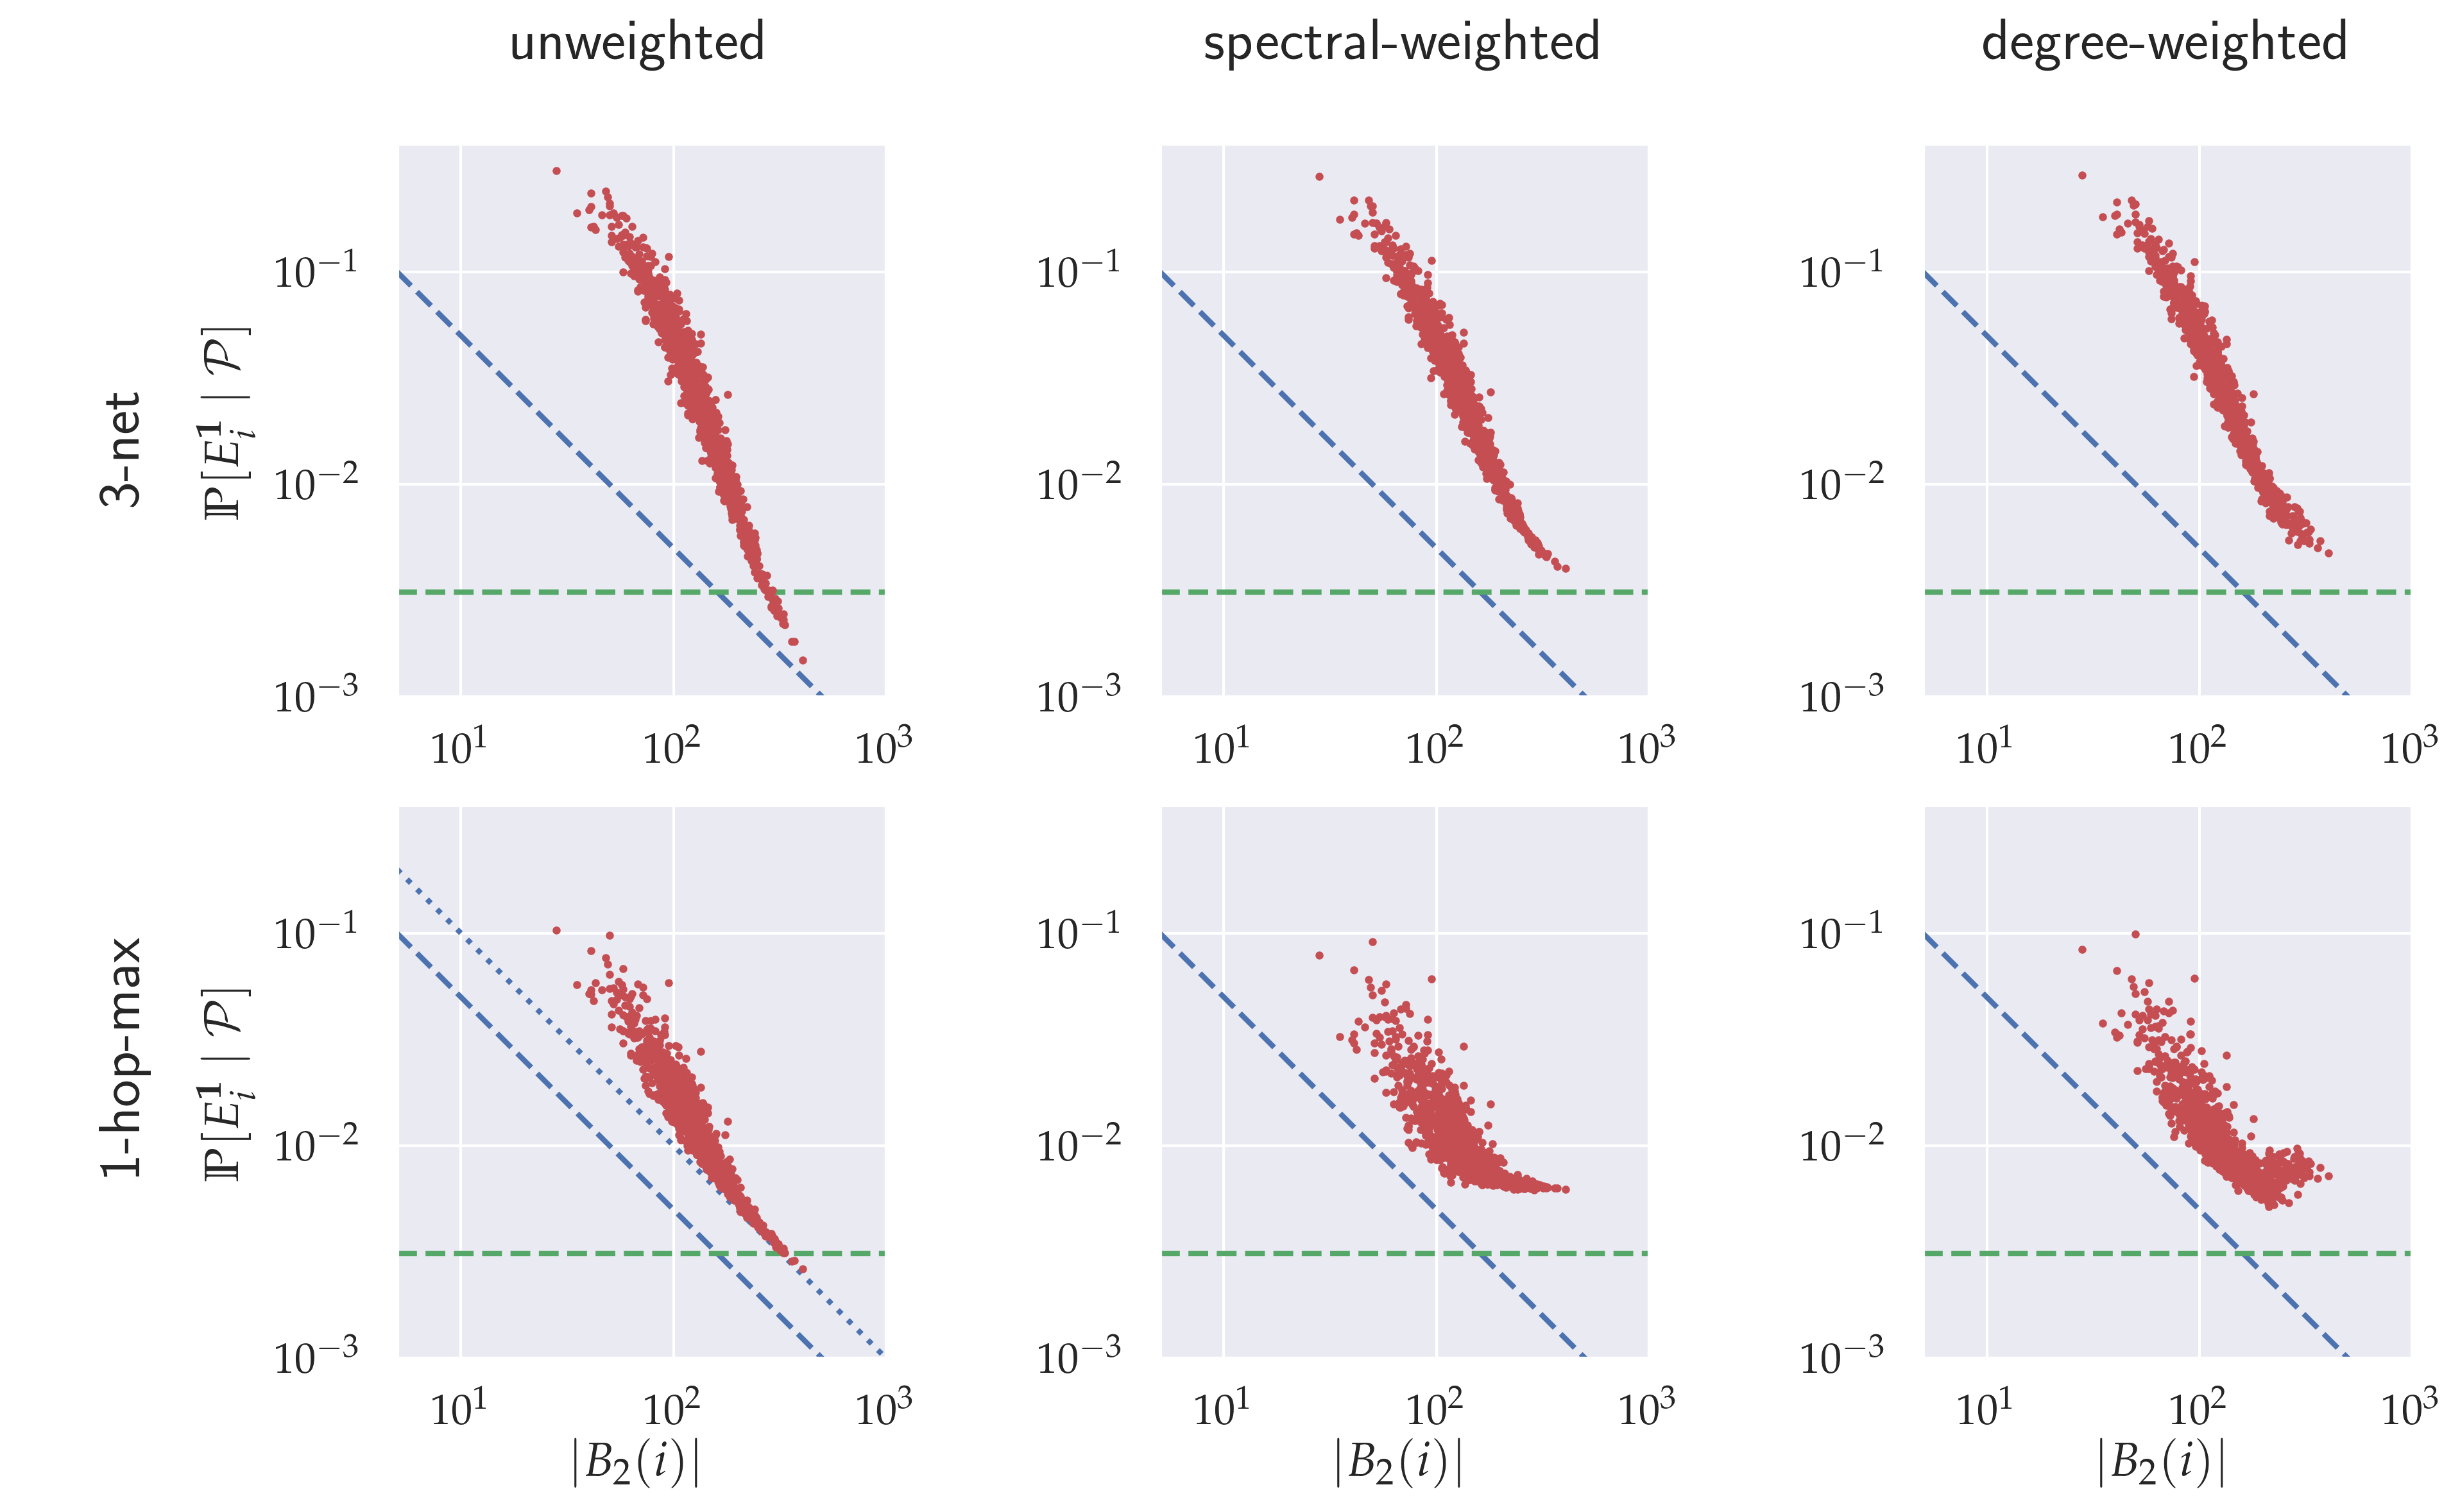

In [5]:
graph_name = 'SW32'
n = 1024
rand = 'ind'

xmin = 5
xmax = 1000
lamb = 161.356

d1 = np.loadtxt('dataset/' + graph_name + '-node_meta.txt', usecols=1, skiprows=1)
d2 = np.loadtxt('dataset/' + graph_name + '-node_meta.txt', usecols=2, skiprows=1)
eig2 = np.loadtxt('dataset/' + graph_name + '-node_meta.txt', usecols=7, skiprows=1)

print(d1.mean(), d1.max())
print(1+d2.mean(), 1+d2.max())

methods = ['r_net-3', 'r_hop_max-1']
weights = ['uniform', 'eig2', 'd1']

# methods = ['r_net-3']
# weights = ['uniform']

fig = plt.figure(figsize=(13,8), dpi=300)
gs = GridSpec(2, 4, width_ratios = [1,4,4,4])
# gs = GridSpec(2, 3, width_ratios = [1,3,3,3])
fsz = 18
ax = plt.subplot(gs[:, 0])
# txt = ax.text(0.15, 0.5, 'Small World', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fsz+8, rotation=90)
txt = ax.text(0.75, 0.75, '3-net', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fsz+4, rotation=90)
txt = ax.text(0.75, 0.25, '1-hop-max', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fsz+4, rotation=90)
# txt.set_clip_on(False)
ax.set_axis_off()

for i, method in enumerate(methods):
    for j, weight in enumerate(weights):
        file_path = 'results/{}_stratified/{}/expo_prob/{}-{}-expo-mix128n-0.txt'.format(rand, graph_name, method, weight)
        prob = np.loadtxt(file_path)
        ax = plt.subplot(gs[i, j+1])
        
        if (method == 'r_hop_max-1' and weight == 'uniform'):
            ax.loglog([xmin, xmax],[1 / xmin, 1 / xmax], ls=':', lw=2, color='b')
        ax.loglog([xmin, xmax],[0.5 / xmin, 0.5 / xmax], ls='--', lw=2, color='b')
        ax.loglog([xmin, xmax],[0.5/lamb, 0.5/lamb], ls='--', lw=2, color='g')
        ax.loglog((d2+1), prob, '.', color='r', ms=4)
        if (i == 0):
            title = 'unweighted'
            if (weight == 'eig2'):
                title = 'spectral-weighted'
            if (weight == 'd1'):
                title = 'degree-weighted'
            ax.set_title(title, fontsize=fsz+4, verticalalignment='center')
            ax.title.set_position([0.5, 1.15])
        if (i == 1):
            ax.set_xlabel(r'$|B_2(i)|$', fontsize=fsz)
        if (j == 0):
            ax.set_ylabel(r'$\mathrm{\mathbb{P}}[E_i ^{\mathbf{1}} \mid \mathcal{P}]$', fontsize=fsz)
        ax.set_xbound(lower=xmin, upper=xmax)
        ax.set_ybound(lower=1e-3, upper=0.4)

        ax.xaxis.set_tick_params(which='major', width=2, size=10)
        ax.xaxis.set_tick_params(which='minor', width=1, size=4)
        ax.yaxis.set_tick_params(which='major', width=2, size=10)
        ax.yaxis.set_tick_params(which='minor', width=1, size=4)
#         ax.grid()

        """ Advanced: set the ticker label size """
        plt.setp(ax.get_xticklabels(), fontsize=fsz-2)  ## setp means 'set property'
        plt.setp(ax.get_yticklabels(), fontsize=fsz-2)
        
        ax.set_aspect('equal', 'box')

fig.tight_layout()
# fig.savefig("fig/prob-SW-all.pdf")
# fig.savefig("fig/prob-SW-all.png")
plt.show()        

In [6]:
graph_name = 'SW32'
n = 1024
rand = 'ind'

# d1 = np.loadtxt(GRAPH_CORE_PATH + graph_name + '-node_meta.txt', usecols=1, skiprows=1)
# d2 = np.loadtxt(GRAPH_CORE_PATH + graph_name + '-node_meta.txt', usecols=2, skiprows=1)
# eig2 = np.loadtxt(GRAPH_CORE_PATH + graph_name + '-node_meta.txt', usecols=7, skiprows=1)
# print('e_vec(i)', eig2[:5])
# print('|B_1(i)|', 1+d1[:5])
# print('|B_2(i)|', 1+d2[:5])

prob = {}
for i, method in enumerate(['r_net-3', 'r_hop_max-1']):
    for j, weight in enumerate(['uniform', 'eig2']):
        file_path = 'results/{}_stratified/{}/expo_prob/{}-{}-expo-mix128n-0.txt'.format(rand, graph_name, method, weight)
        prob[method+'--'+weight] = np.loadtxt(file_path)        

In [7]:
def make_plot(prob, xopt, yopt, xl, yl):
    fsz = 18
    xy_min = min(prob[xopt].min(), prob[yopt].min())
    xy_max = max(prob[xopt].max(), prob[yopt].max())
    ax.loglog(prob[xopt], prob[yopt], '.', ms=2)
    ax.loglog([xy_min,xy_max], [xy_min,xy_max], '--', lw=2)
    ax.axis('equal')
    ax.set_xlabel(xl, fontsize=fsz)
    ax.set_ylabel(yl, fontsize=fsz)
    ax.set_xlim([xy_min, xy_max])
    ax.set_ylim([xy_min, xy_max])
    ax.set_xbound(lower=xy_min, upper=xy_max)
    ax.set_ybound(lower=xy_min, upper=xy_max)

    ax.xaxis.set_tick_params(which='major', width=2, size=10)
    ax.xaxis.set_tick_params(which='minor', width=1, size=4)
    ax.yaxis.set_tick_params(which='major', width=2, size=10)
    ax.yaxis.set_tick_params(which='minor', width=1, size=4)

    """ Advanced: set the ticker label size """
    plt.setp(ax.get_xticklabels(), fontsize=fsz-2)  ## setp means 'set property'
    plt.setp(ax.get_yticklabels(), fontsize=fsz-2)
        
    ax.set_aspect('equal', 'box')

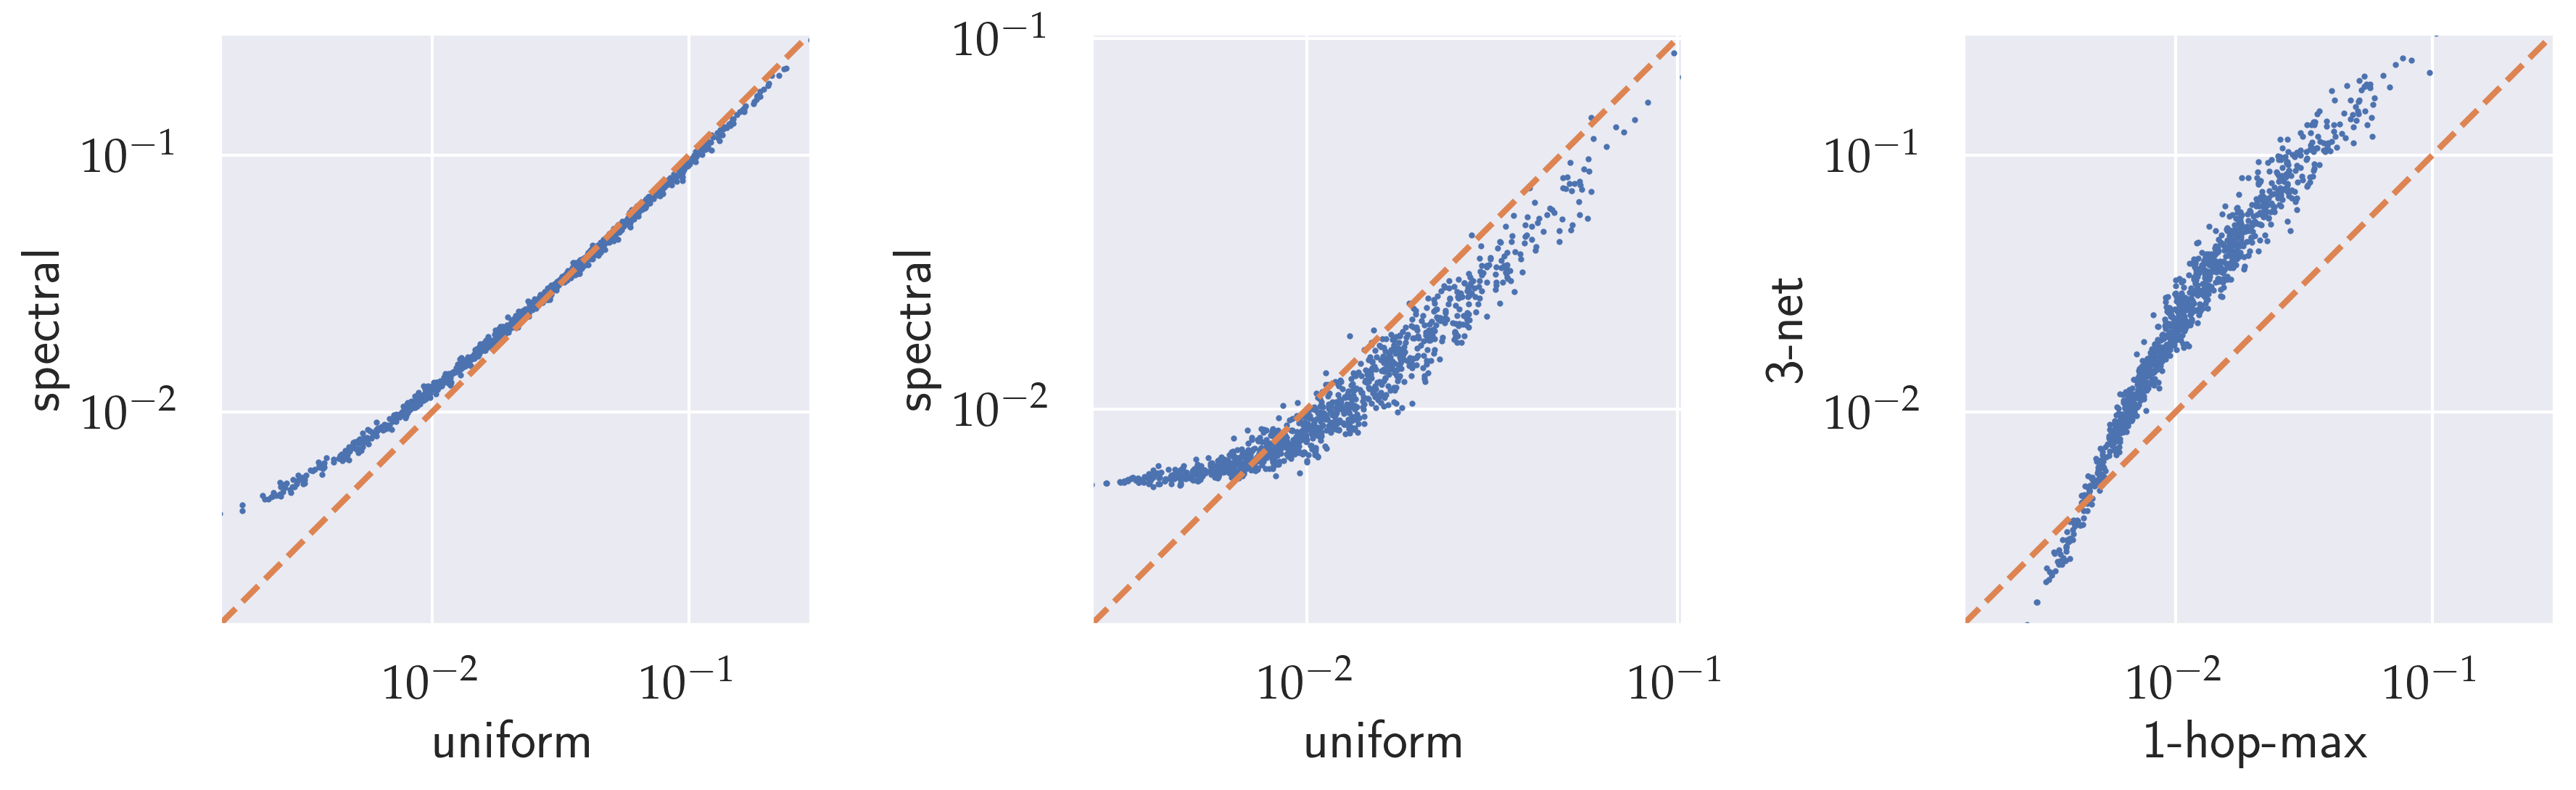

In [8]:
fig = plt.figure(figsize=(12, 4), dpi=300)
ax = plt.subplot(131)
make_plot(prob, 'r_net-3--uniform', 'r_net-3--eig2', 'uniform', 'spectral')
ax = plt.subplot(132)
make_plot(prob, 'r_hop_max-1--uniform', 'r_hop_max-1--eig2', 'uniform', 'spectral')
ax = plt.subplot(133)
make_plot(prob, 'r_hop_max-1--uniform', 'r_net-3--uniform', '1-hop-max', '3-net')
plt.tight_layout()
plt.show()

# 5. Compute variance of HT estimator under RGCR

To reproduce Fig 7 on SW32, first make sure all the commands in Section "Estimate exposure probabilities" are completed, then execute the following commands:

    ./compute_rgcr_variance -g SW32 -c [method]-[weight] -s mix128n-0.txt -m -o SW32
    ./compute_rgcr_variance -g SW32 -c [method]-[weight] -s mix128n-0.txt -m -o SW32 -r

again for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~5 seconds to execute.

After completing all the commands above, execute the following cells.

In [9]:
def read_variance_formula(filename, n_lines, path=''):
    fin = open(path+filename, 'r')
    results = []
    for i in range(n_lines):
        next(fin)
        results.append([float(s) for s in fin.readline().strip().split()])
    return np.array(results)

In [10]:
x = np.array([1, 5, 10, 14])
width = 1
weights = ['uniform', 'spectral', 'degree']
labels = [
    '3-net--ind',
    '3-net--com',
    '1-hop-max--ind',
    '1-hop-max--com',
]
indices = np.array([0, 6, 3, 9])


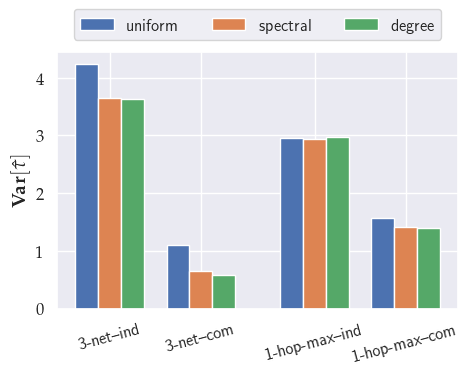

In [11]:
variance_HT = read_variance_formula('results/variances-HT-SW32.txt', 12)[:, 0]
fsz = 12
fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    result_i = variance_HT[i+indices]
    ax.bar(x+i, result_i, width, label=weights[i])

ax.set_ylabel(r'$\mathbf{Var}[\hat{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.set_title('Variance of HT estimator')
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
# ax.legend(fontsize=fsz, loc=(0.24,0.67))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-HT-SW96.pdf')
plt.show()


# 6. Simulate bias/variance/MSE of Hajek-estimator under RGCR

To reproduce Fig 9 on SW32, first make sure the commands in the above section have completed, and then execute the following commands:

    ./simulate_rgcr_variance -g SW32 -c [method] -w [weight] -s mix128n-0.txt -h Hajek -m -n 50 -o SW32
    ./simulate_rgcr_variance -g SW32 -c [method] -w [weight] -s mix128n-0.txt -h Hajek -m -n 50 -o SW32 -r

for [method] in {r_net-3, r_hop_max-1} and [weight] in {uniform, d1, eig2}.
Each command takes ~1 minute to execute.
Note that the four columns in the output file simulation-Hajek-SW32.txt are
* estimated bias;
* std of the estimated bias;
* estimated MSE;
* std of the estimated MSE.


After completing all the commands above, execute the following cells. 

In [12]:
def read_variance_simulation(filename, n_lines, path=''):
    fin = open(path+filename, 'r')
    results = []
    for i in range(n_lines):
        next(fin)
        next(fin)
        results.append([float(s) for s in fin.readline().strip().split()])
    return np.array(results)

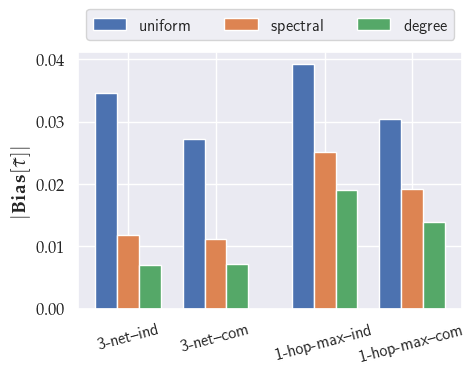

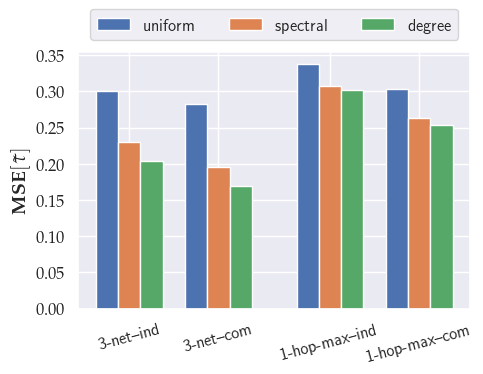

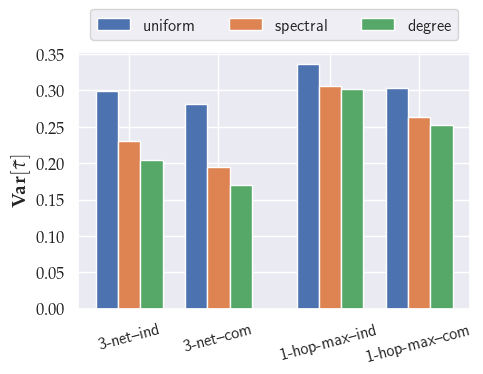

In [13]:
results = read_variance_simulation('results/simulation-Hajek-SW32.txt', 12)
fsz = 12

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 0]
    ax.bar(x+i, np.abs(bias_i), width, label=weights[i])
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-Bias-SW96.pdf')
plt.show()

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 2]
    ax.bar(x+i, bias_i, width, label=weights[i])
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-MSE-SW96.pdf')
plt.show()

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.gca()
for i in range(3):
    bias_i = results[i+indices, 2] - results[i+indices, 0] * results[i+indices, 0]
    ax.bar(x+i, bias_i, width, label=weights[i])
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+1)
ax.set_xticklabels(labels, rotation=15, fontsize=fsz)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/RGCR-Hajek-Var-SW96.pdf')
plt.show()

# 7. Compare Hajek estimator bias/variance/MSE under RGCR and GCR

To reproduce Fig 8 on SW32, first execute the following commands:

    ./simulate_gcr_variance -g SW32 -c r_net-3 -w [weight] -h Hajek -n 100000 -k 1000 -m -t 1 -o SW32-[weight]

for [weight] in {uniform, d1, eig2}.
Each command takes ~15 minutes.
Again the four columns in each output file are
* estimated bias;
* std of the estimated bias;
* estimated MSE;
* std of the estimated MSE.


After completing all the commands above, execute the following cells. 

In [14]:
def read_gcr_simulation_median(suffix):
    filename = 'results/simulation-GCR-Hajek-{}.txt'.format(suffix)
    results_gcr = np.loadtxt(filename, skiprows=2, max_rows=1000)
    bias = np.quantile(results_gcr[:,0], 0.5)
    mse = np.quantile(results_gcr[:,2], 0.5)
    fin = open(filename, 'r')
    next(fin)
    GATE_gt = float(fin.readline()[7:])
    return bias, mse, GATE_gt

In [15]:
def read_gcr_weights(graph_name):
    bias_gcr = []
    mse_gcr = []
    gate_gt = []
    for w in ['uniform', 'eig2', 'd1']:
        bias, mse, GATE_gt = read_gcr_simulation_median(graph_name + '-' + w)
        bias_gcr.append(bias)
        mse_gcr.append(mse)
        gate_gt.append(GATE_gt)
    return np.array(bias_gcr), np.array(mse_gcr), np.array(gate_gt)


In [16]:
x = np.array([1, 4, 7])
width = 1
weights = ['uniform', 'spectral', 'degree']

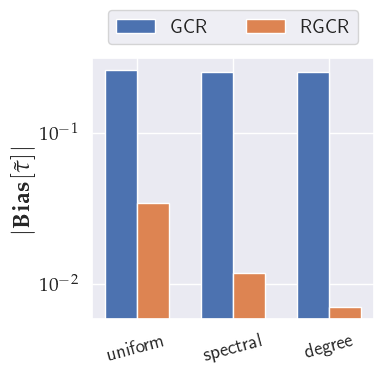

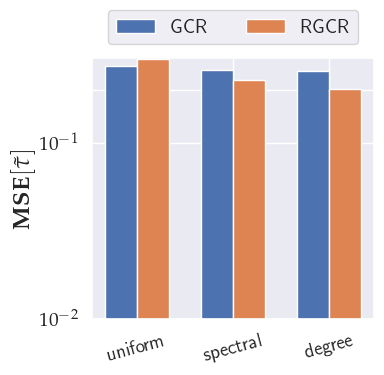

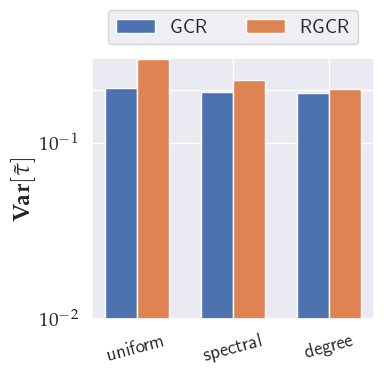

In [17]:
graph_name = "SW32"
gcr_results = read_gcr_weights(graph_name)
rgcr_results = read_variance_simulation('results/simulation-Hajek-{}.txt'.format(graph_name), 3)
# rgcr_results = read_variance_simulation('results/simulation-Hajek-SW32.txt', 12)



fsz = 14

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, np.abs(gcr_results[0]), width, label='GCR')
ax.bar(x+1, np.abs(rgcr_results[:,0]), width, label='RGCR')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(weights, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-Bias-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(weights, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 0.2])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-MSE-{}.pdf'.format(graph_name))
plt.show()

fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.gca()
ax.bar(x, gcr_results[1] - gcr_results[0] * gcr_results[0], width, label='GCR')
ax.bar(x+1, rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0], width, label='RGCR')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.set_xticks(x+0.5)
ax.set_xticklabels(weights, rotation=15, fontsize=fsz)
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 0.2])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-Var-{}.pdf'.format(graph_name))
plt.show()

# fig = plt.figure(figsize=(4, 4), dpi=100)
# ax = fig.gca()
# ax.bar(x, (gcr_results[1] - gcr_results[0] * gcr_results[0]) / (gcr_results[2] + gcr_results[0])/(gcr_results[2] + gcr_results[0]), width, label='GCR')
# ax.bar(x+1, (rgcr_results[:,2] - rgcr_results[:,0] * rgcr_results[:,0]) / (gcr_results[2] + rgcr_results[:,0])/(gcr_results[2] + rgcr_results[:,0]), width, label='RGCR')
# ax.set_ylabel(r'Scaled $\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+3)
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.set_xticks(x+0.5)
# ax.set_xticklabels(labels_sim, rotation=15, fontsize=fsz)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), fancybox=True, fontsize=fsz, ncol=3)
# fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-ScaVar-{}.pdf'.format(graph_name))
# plt.show()

# 8. Bias/variance/MSE decay with network size

To reproduce Fig 10, first estimate the RGCR exposure probabilities for (3-net clustering, uniform weight, independent randomization) for all small-world networks SW[x], where x ranges from [16, 24, 32, 48, 64, 96]. Please refer for Section 4 for commands to do that.

After the exposure probabilities are estimated (and dumped to directory results/ind_stratified, run the following commands

    /compute_rgcr_variance -g SW[x] -c r_net-3-uniform -s mix128n-0.txt -m -o SWx
    ./simulate_rgcr_variance -g SW[x] -c r_net-3 -w uniform -s mix128n-0.txt -h Hajek -m -n 50 -o SWx

for [x] in [16, 24, 32, 48, 64, 96]. This would compute the HT-estimator variance and simulate Hajek estimator bias/variance/MSE under RGCR. Additionally, run

    ./simulate_gcr_variance -g SW[x] -c r_net-3 -w uniform -h Hajek -n 100000 -k 1000 -m -t 1 -o SW[x]-uniform

to simulate Hajek estimator bias/variance/MSE under GCR.

After completing all the commands above, execute the following cells. 

In [18]:
def read_gcr_graphs(graph_names, method):
    bias_gcr = []
    mse_gcr = []
    gate_gt = []
    for graph_name in graph_names:
        bias, mse, GATE_gt = read_gcr_simulation_median(graph_name+'-'+method)
        bias_gcr.append(bias)
        mse_gcr.append(mse)
        gate_gt.append(GATE_gt)
    return np.array(bias_gcr), np.array(mse_gcr)#, np.array(gate_gt)


In [19]:
graph_names = [
    'SW16',
    'SW24',
    'SW32',
    'SW48',
    'SW64',
    'SW96',
]

L = np.array([int(s[2:]) for s in graph_names])

n = L ** 2

m = np.array([
	1597,
	3452,
	6139,
	13626,
	24713,
	55214,
])

print(2 * m / n)

[12.4765625  11.98611111 11.99023438 11.828125   12.06689453 11.98220486]


In [20]:
method = 'uniform'
# method = 'eig2'

bias_gcr, mse_gcr = read_gcr_graphs(graph_names, method)
print(bias_gcr)
print(mse_gcr)

results_rgcr = read_variance_simulation('results/simulation-Hajek-SWx.txt', 6)
print(results_rgcr[:,0])
print(results_rgcr[:,2])

[-0.30444   -0.2554475 -0.2634825 -0.2200885 -0.2159245 -0.184855 ]
[0.3057715 0.218734  0.275794  0.2306335 0.209246  0.183087 ]
[-0.156836   -0.0628872  -0.0352327  -0.014056   -0.00797139 -0.00342273]
[0.475336  0.342699  0.300973  0.151247  0.0888725 0.0451322]


In [21]:
variance_HT = read_variance_formula('results/variances-HT-SWx.txt', 6)[:, 0]
print(variance_HT)

[30.5932    9.91446   4.23349   1.42991   0.745507  0.310246]


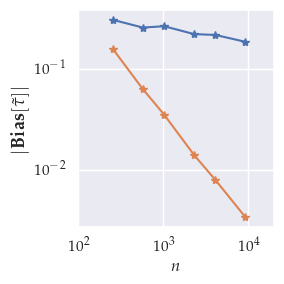

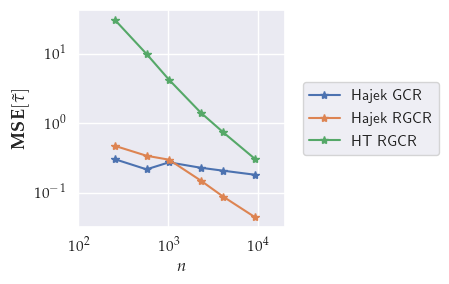

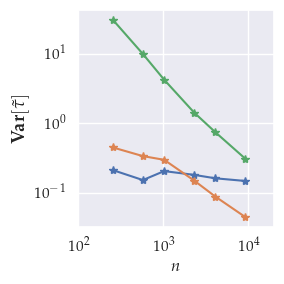

In [22]:
fsz = 11

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = plt.gca()
ax.plot(n, -bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, -results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$|\mathbf{Bias}[\tilde{\tau}]|$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-Bias-SWx.pdf')
plt.show()

fig = plt.figure(figsize=(4.73, 3), dpi=100)
ax = plt.gca()
ax.plot(n, mse_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\mathbf{MSE}[\tilde{\tau}]$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=fsz)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-MSE-SWx.pdf')
plt.show()

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = plt.gca()
ax.plot(n, mse_gcr - bias_gcr * bias_gcr, '*-', label='Hajek GCR')
ax.plot(n, results_rgcr[:,2] - results_rgcr[:,0] * results_rgcr[:,0], '*-', label='Hajek RGCR')
ax.plot(n, variance_HT, '*-', label='HT RGCR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\mathbf{Var}[\tilde{\tau}]$', fontsize=fsz+2)
ax.set_xlim(100, 20000)
plt.xticks([100, 1000, 10000])
# plt.setp(ax.get_yticklabels(), fontsize=fsz)
# ax.legend(loc='lower left', fontsize=fsz)
fig.tight_layout()
# fig.savefig('fig/GCR-Hajek-Var-SWx.pdf')
plt.show()


# Appendix A. Compute ball size

We also provide the code to analyze the network growth rate, an experiment conducted in Appendix A of the main paper.

We compute the size of ball of various radius centered at each node of the network. It is implemented with the naive BFS algorithm. 

To compute the ball sizes of network SW96, and dump the result to disk, use command

    ./compute_ball_size SW96
    
After it is completed, you can reproduce Fig 12 by executing the cells below.

In [23]:
def get_col_name(PFName):
    fin = open(PFName)
    s = fin.readline().strip()
    fin.close()
    return s.split('\t')

In [24]:
def plot_ball_size(PGName):
    PFName = 'results/ball_size/' + PGName+'-ball_size.txt'
    col_names = get_col_name(PFName)
    diameter = len(col_names) - 1
    ball_sizes = np.loadtxt(PFName, dtype='float', usecols=range(1, diameter+1), skiprows=1)
    n = ball_sizes.shape[0]
    deg_max = ball_sizes[:,0].max() - 1
    if diameter < 100:
        print("max ball size: ", ball_sizes.max(axis=0))
        print("avg ball size: ", ball_sizes.mean(axis=0))
    # ball_sizes /= ball_sizes[0, -1]

    fig = plt.figure(figsize=(4, 2), dpi=800)
    
    ax = plt.subplot(121)
    fsz = 10
    ax.boxplot(ball_sizes, whis=[5,95], showfliers=True, labels=range(1, diameter+1), sym='r.')
    # ax.boxplot(ball_sizes, whis=[5,95])
    ax.set_xlabel(r"$r$", fontsize=fsz)
    ax.set_ylabel(r"$|B_r(u)|$", fontsize=fsz)
    ax.xaxis.set_tick_params(which='major', width=2, size=5)
    ax.xaxis.set_tick_params(which='minor', width=1, size=2)
    ax.yaxis.set_tick_params(which='major', width=2, size=5)
    ax.yaxis.set_tick_params(which='minor', width=1, size=2)
    plt.setp(ax.get_xticklabels(), fontsize=fsz-4)  ## setp means 'set property'
    plt.setp(ax.get_yticklabels(), fontsize=fsz-4)
    ax.grid()

    kappa = ball_sizes[:, 1:] / ball_sizes[:, :-1]
    kappa_max = kappa.max()
    UB1 = deg_max**2 * kappa_max**4 / n * 2
    UB2 = (ball_sizes[:,1] * ball_sizes[:,3]).mean() / n * 2
    UB3 = np.sqrt((ball_sizes[:,1]**2).mean() * (ball_sizes[:,3]**2).mean()) / n * 2
    LB = (ball_sizes[:,1]).mean() / n * 2
    print("d_max = ", deg_max)
    print("kappa: ", kappa_max)
#     print("UB1: d_max^2 kappa^4 / n = \t{:e}".format(UB1))
#     print("UB2: mean(|B_2(u)||B_4(u)|)/n = \t{:e}".format(UB2))
#     print("UB3: Cauchy-Schwartz of UB2 = \t{:e}".format(UB3))
#     print("UB1 / UB2 = \t\t\t{:e}".format(UB1/UB2))
#     print("Without cross terms: mean(|B_2(u)|)/m = \t{:e}".format(LB))

    ax = plt.subplot(122)
    ax.boxplot(np.hstack([ball_sizes[:,0].reshape(-1, 1), kappa]), whis=[5,95], showfliers=True, labels=range(0, diameter), sym='r.')
    # ax.boxplot(ball_sizes, whis=[5,95])
    ax.set_xlabel(r"$r$", fontsize=fsz)
    ax.set_ylabel(r"$\kappa_r(u)$", fontsize=fsz)
    ax.xaxis.set_tick_params(which='major', width=2, size=5)
    ax.xaxis.set_tick_params(which='minor', width=1, size=2)
    ax.yaxis.set_tick_params(which='major', width=2, size=5)
    ax.yaxis.set_tick_params(which='minor', width=1, size=2)
    plt.setp(ax.get_xticklabels(), fontsize=fsz-4)  ## setp means 'set property'
    plt.setp(ax.get_yticklabels(), fontsize=fsz-4)
    ax.grid()
    
    plt.tight_layout()
    plt.show()

max ball size:  [  43.  538. 4215. 9060. 9216. 9216.]
avg ball size:  [  12.98220486  156.80533854 1485.58723958 6775.39322917 9196.98546007
 9216.        ]
d_max =  42.0
kappa:  21.8


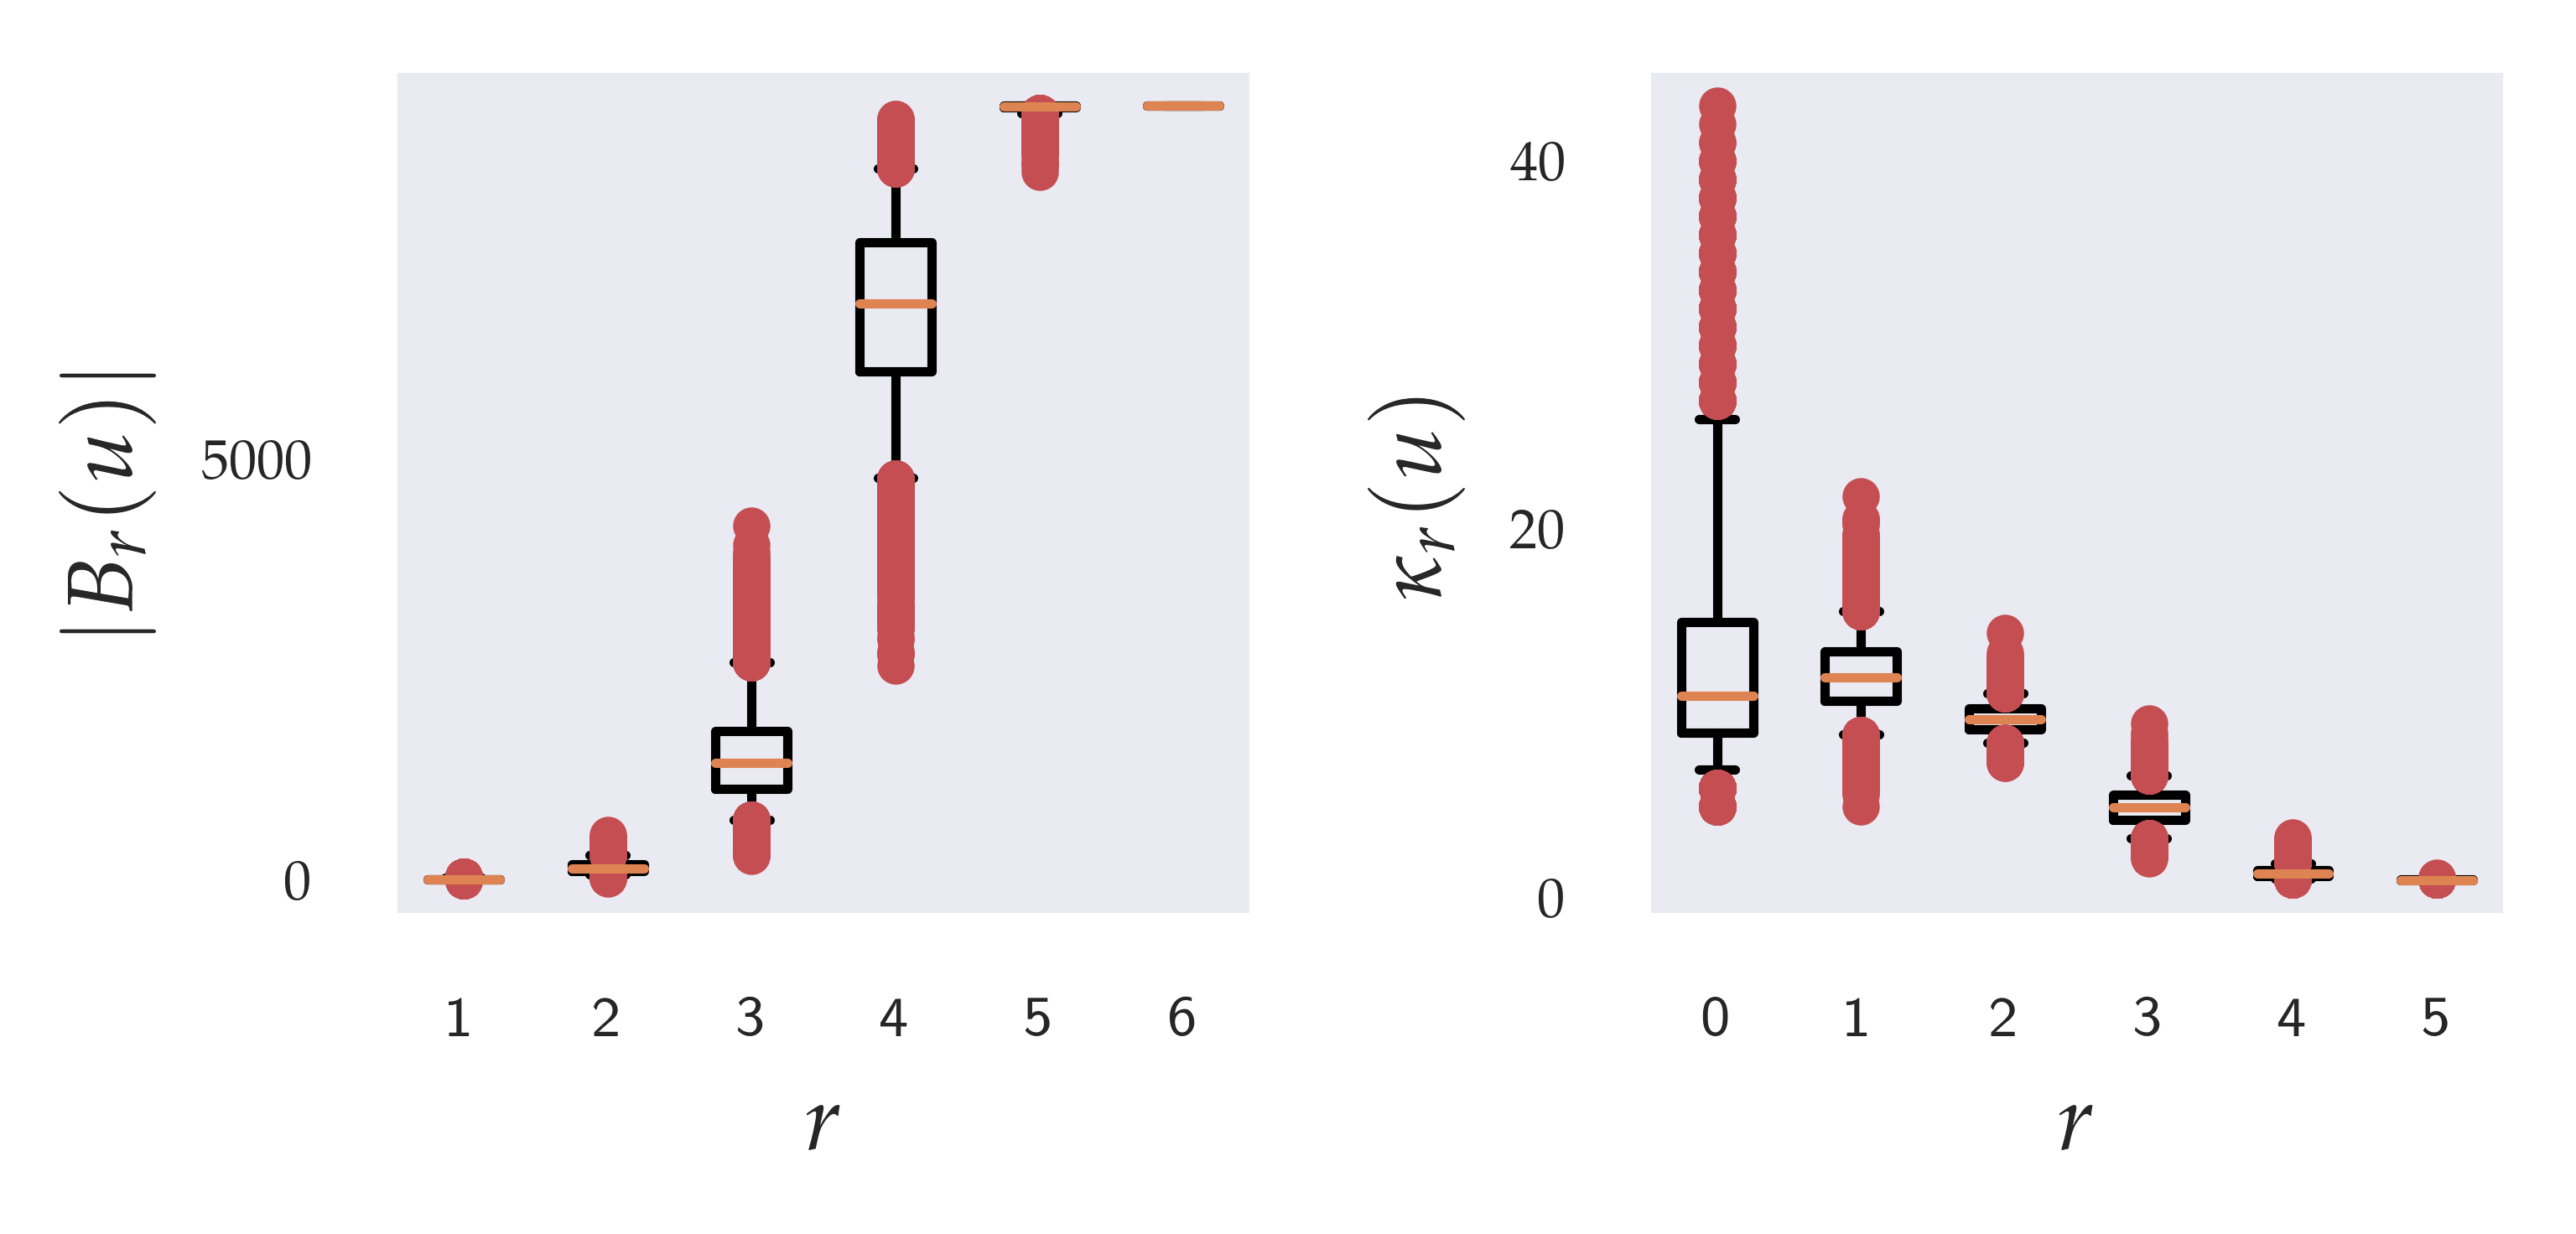

In [25]:
plot_ball_size('SW96')

If you have the FB100 dataset, and put all the networks in the format of edgelist in directory dataset/FB100/, say
* dataset/FB100/Harvard1
* dataset/FB100/Columbia2
* dataset/FB100/Stanford3
* ...

You can run the cell below to compute the ball_size for all networks:

and then reproduce Fig 12 for FB-Stanford with

max ball size:  [ 1173.  9782. 11477. 11581. 11586. 11586. 11586. 11586. 11586.]
avg ball size:  [   99.10271017  3910.36578629  9882.2285517  11402.31399965
 11570.30277922 11583.80355602 11585.80959779 11585.99240463
 11586.        ]
d_max =  1172.0
kappa:  586.5


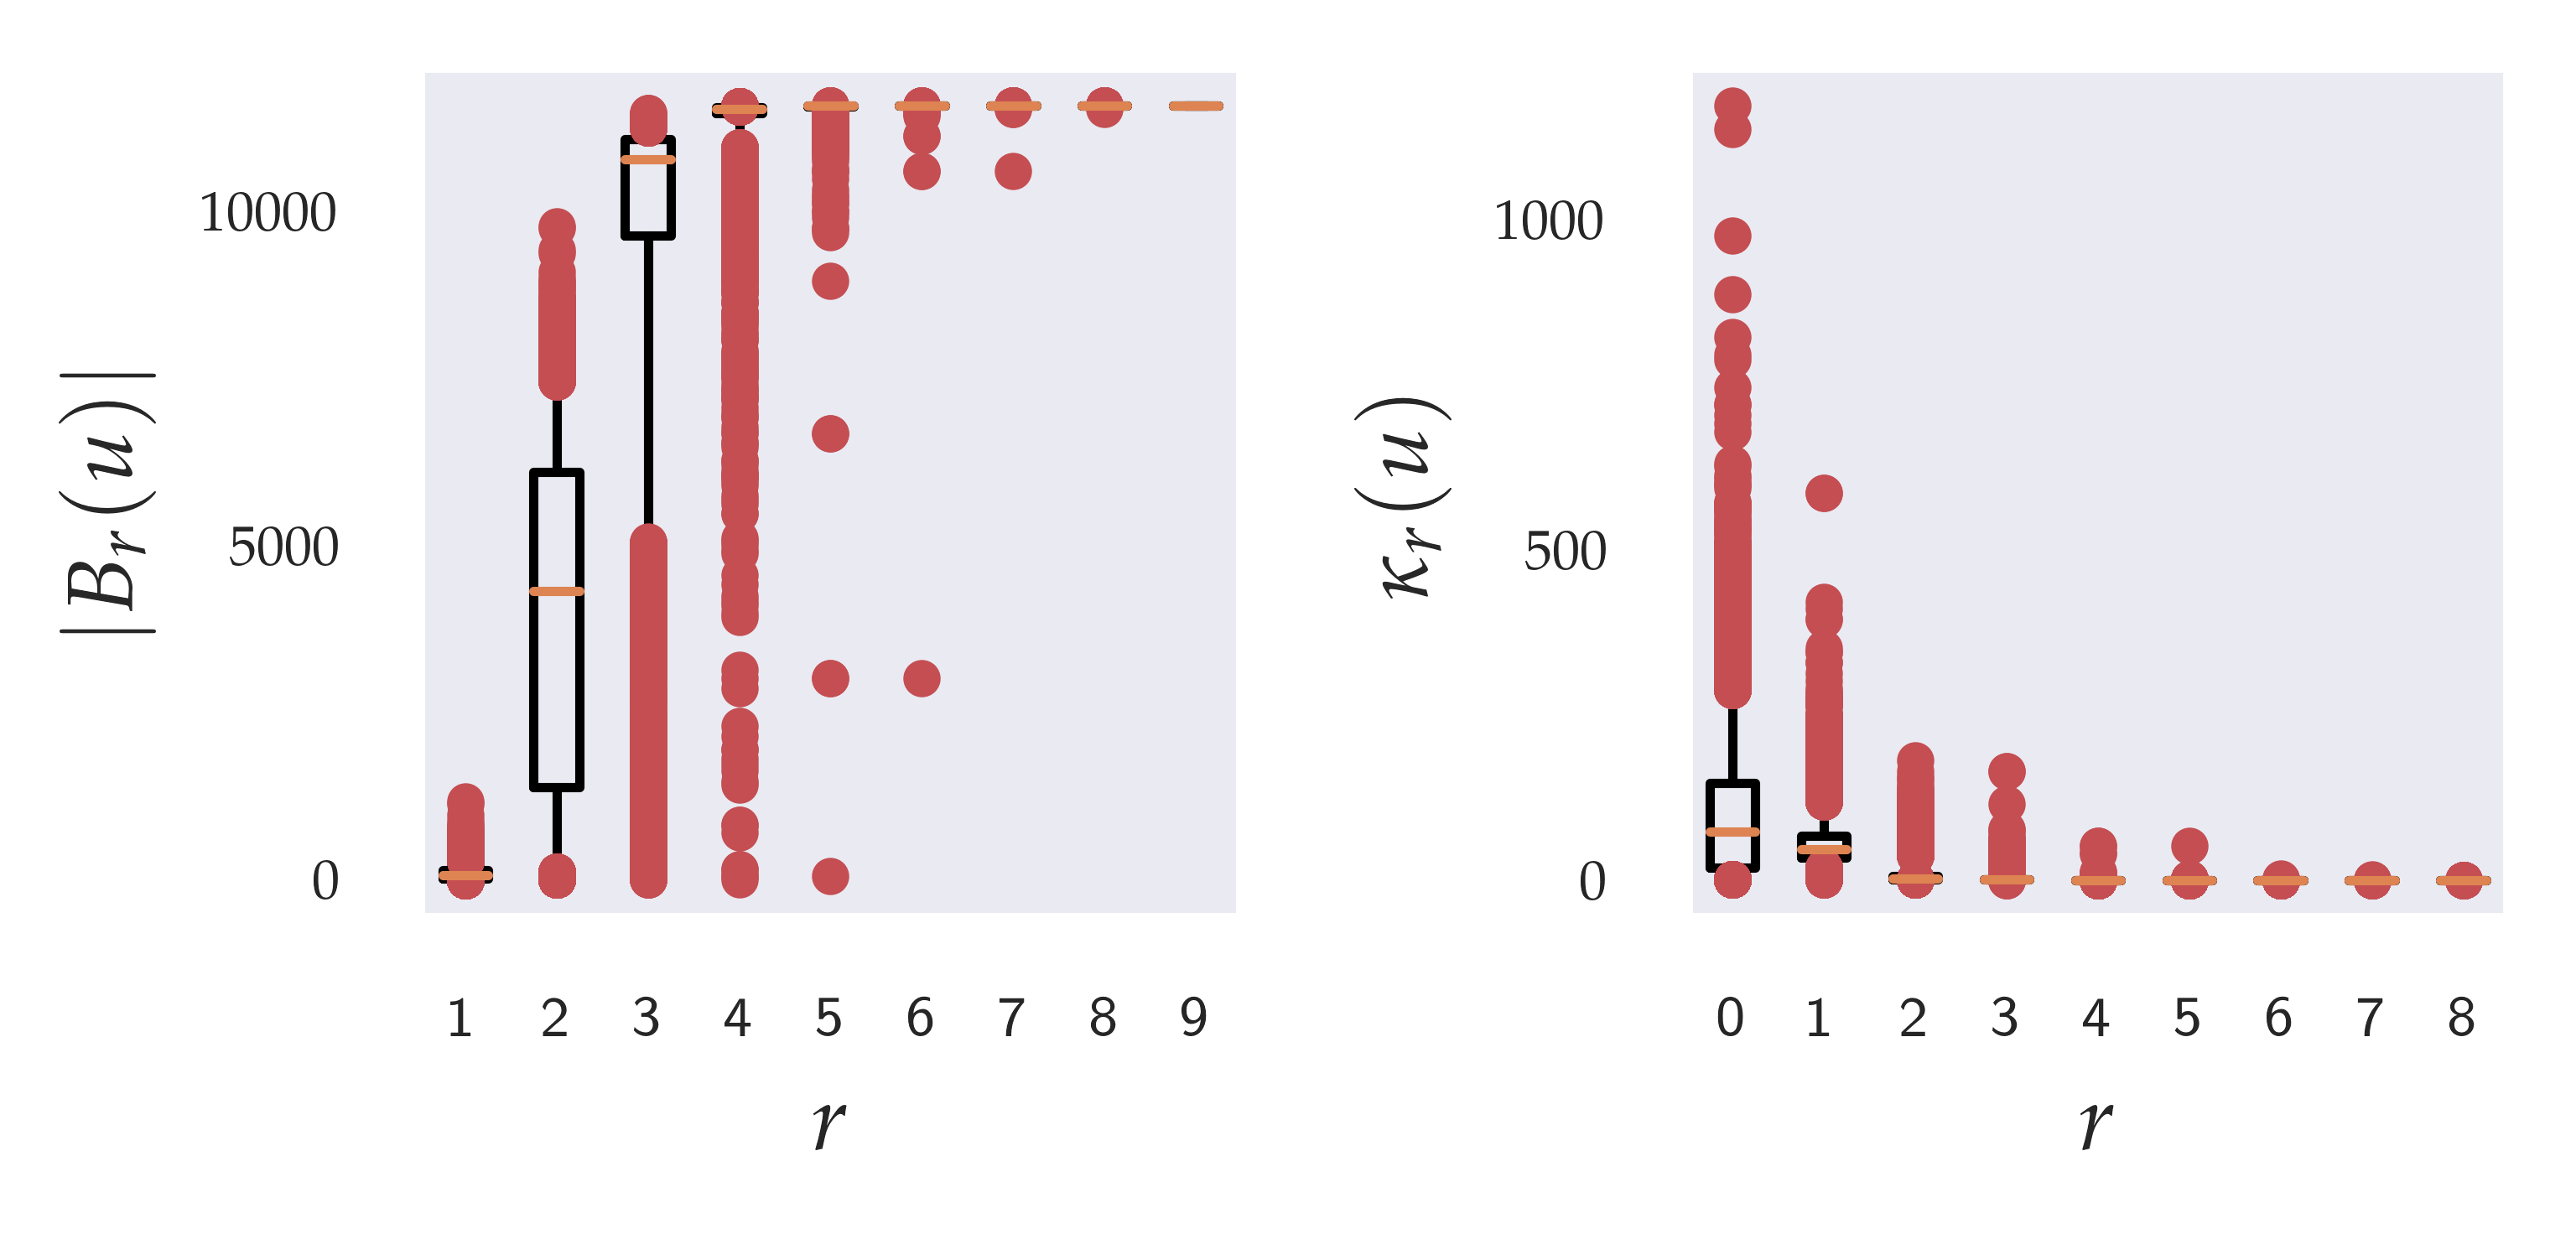

In [26]:
plot_ball_size('FB100/Stanford3')

You can reproduce Fig 11 with the following cells:

In [27]:
def get_mean_max_ball_size(file_name):
    col_names = get_col_name(file_name)
    diameter = len(col_names) - 1
    ball_sizes = np.loadtxt(file_name, dtype='float', usecols=range(1, diameter+1), skiprows=1)
    n = ball_sizes.shape[0]
    mean_ball_size = ball_sizes.mean(axis=0)
    mean_ball_size = np.hstack([[1], mean_ball_size])
    mean_ball_size /= mean_ball_size[-1]
    max_ball_size = ball_sizes.max(axis=0)
    max_ball_size = np.hstack([[1], max_ball_size])
    max_ball_size /= max_ball_size[-1]
    
    return n, mean_ball_size, max_ball_size
    

In [28]:
path = 'results/ball_size/FB100/'

mean_ball_sizes = []
max_ball_sizes = []
n_nodes = []

for graph_name in os.listdir(path):
    if not graph_name.endswith('.txt'):
        continue
    result = get_mean_max_ball_size(path + graph_name)
    n_nodes.append(result[0])
    mean_ball_sizes.append(result[1])
    max_ball_sizes.append(result[2])

n_max = max(n_nodes)
n_min = min(n_nodes)

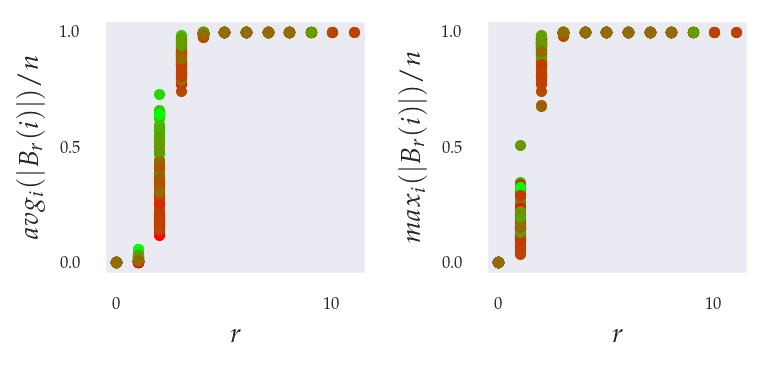

In [29]:
fig = plt.figure(figsize=(4, 2), dpi=200)
fsz = 10

ax = plt.subplot(121)
for n, mean_ball_size in zip(n_nodes, mean_ball_sizes):
    c = (np.log(n) - np.log(n_min)) / (np.log(n_max) - np.log(n_min))
    ax.plot(mean_ball_size, '.', lw=1, color=(c, 1-c, 0))
ax.set_xlabel(r"$r$", fontsize=fsz)
ax.set_ylabel(r"$avg_i(|B_r(i)|)/n$", fontsize=fsz)
ax.xaxis.set_tick_params(which='major', width=2, size=5)
ax.xaxis.set_tick_params(which='minor', width=1, size=2)
ax.yaxis.set_tick_params(which='major', width=2, size=5)
ax.yaxis.set_tick_params(which='minor', width=1, size=2)
plt.setp(ax.get_xticklabels(), fontsize=fsz-4)  ## setp means 'set property'
plt.setp(ax.get_yticklabels(), fontsize=fsz-4)
ax.grid()

ax = plt.subplot(122)
for n, max_ball_size in zip(n_nodes, max_ball_sizes):
    c = (np.log(n) - np.log(n_min)) / (np.log(n_max) - np.log(n_min))
    ax.plot(max_ball_size, '.', lw=1, color=(c, 1-c, 0))
ax.set_xlabel(r"$r$", fontsize=fsz)
ax.set_ylabel(r"$max_i(|B_r(i)|)/n$", fontsize=fsz)
ax.xaxis.set_tick_params(which='major', width=2, size=5)
ax.xaxis.set_tick_params(which='minor', width=1, size=2)
ax.yaxis.set_tick_params(which='major', width=2, size=5)
ax.yaxis.set_tick_params(which='minor', width=1, size=2)
plt.setp(ax.get_xticklabels(), fontsize=fsz-4)  ## setp means 'set property'
plt.setp(ax.get_yticklabels(), fontsize=fsz-4)
ax.grid()

# ax = plt.subplot(122)
# ax.plot(range(diameter+1), max_ball_size)
# ax.set_xlabel(r"$r$", fontsize=fsz)
# ax.set_ylabel(r"$max(|B_r(u)|)$", fontsize=fsz)
# ax.xaxis.set_tick_params(which='major', width=2, size=5)
# ax.xaxis.set_tick_params(which='minor', width=1, size=2)
# ax.yaxis.set_tick_params(which='major', width=2, size=5)
# ax.yaxis.set_tick_params(which='minor', width=1, size=2)
# plt.setp(ax.get_xticklabels(), fontsize=fsz-4)  ## setp means 'set property'
# plt.setp(ax.get_yticklabels(), fontsize=fsz-4)
# ax.grid()

plt.tight_layout()
plt.show()